<a href="https://colab.research.google.com/github/dequiroz/1MTR53_RobIA/blob/main/Planificaci%C3%B3n_de_trayectorias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?export=view&id=1FsTa2YzWwxY-HBkd2EOXAlkPJ1zpikWv" alt="drawing" width="150"/>


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1VBn7nKlruxCPLHH_UuD8B2pkvKP7JLRd" alt="drawing" width="800"/>

</br>

<img src="https://drive.google.com/uc?export=view&id=1uF_4x1YqLuS3M0mlh3NrMrEUHvjBMBFw" alt="drawing" width="800"/>
</p>

#Planificación de Trayectorias
* Diego Quiroz Velasquez
* Pontificia Universidad Católica del Perú
* Sección Ingeniería Mecatrónica

---
Este archivo presenta una implementación del algoritmo de Dijkstra y A* aplicados para la planificación de trayectorias en un vehículo movil.

<img src="https://drive.google.com/uc?export=view&id=1vgFoFHEKMN0WcAFlKS2hPMg2KuBm3sp9" alt="drawing"/>



Se ha visto en clase que los algoritmos de planificación de trayectorias deben mantener una pila en su memoría en la cual van almacenando las celdas disponible a analizar, entre las cuales se selcciona aquella que presenta un menor peso para ser la siguiente a analizar.

Determinar la celda con el menor peso impleca realizar una busqueda, proceso que no es eficiente para realizar en python, por lo que si se desea emplear una lista, podemos primero ordenarla mediante la función `sort()` y luego extrar un valor mediante la función `pop()`

Por defecto, la función `pop()` extra el último valor de una lista, por lo si queremos el valor máx bajo debemos ordenar la lista de mayor a menor. Esto podemos hacerlo con la fución `sort()` empleando el parametro `reverse`

In [1]:
# Se inicializa una lista
li = [5, 7, 9, 1, 3]

# Se ordena la lista
li.sort(reverse = True)

print(f'lista ordenada: {li}')
print(f'valor más bajo: {li.pop()}')
print(f'lista remanente: {li}')

lista ordenada: [9, 7, 5, 3, 1]
valor más bajo: 1
lista remanente: [9, 7, 5, 3]


Una seguna alternativa es indicar a `pop()` el indice del item a extraer

In [2]:
# Se inicializa una lista
li = [5, 7, 9, 1, 3]

# Se ordena la lista
li.sort()

print(f'lista ordenada: {li}')
print(f'valor más bajo: {li.pop(0)}')
print(f'lista remanente: {li}')

lista ordenada: [1, 3, 5, 7, 9]
valor más bajo: 1
lista remanente: [3, 5, 7, 9]


Esta operación funciona bien para comprender el procedimiento de ordenar una pila y extraer un valor en python; sin embargo durante el resto del archivo emplearemos Heap queue (`heapq`), una estructura que ha sido desarrollada para implementar pilas con prioridad de forma eficiente.


In [3]:
import heapq

# Se inicializa una lista
li = [5, 7, 9, 1, 3]

#Convertir la lista a una pila
heapq.heapify(li)

print(f'Pila: {li}')
print(f'valor más bajo: {heapq.heappop(li)}')
print(f'Pila remanente: {li}')

Pila: [1, 3, 9, 7, 5]
valor más bajo: 1
Pila remanente: [3, 5, 9, 7]


#Algoritmo de Dijkstra

A continuación se presentan las funciones para encontrar la ruta óptima (más corta) para navegar un mapa de traversabilidad como el mostrado a continuación. Las casillas negras, representadas por un `0` en el mapa de transibilidad implica la presencia de un obstáculo.

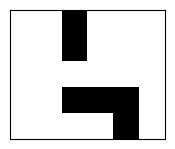

In [4]:
# @title show_map()
import matplotlib.pyplot as plt
import numpy as np

def show_map(map):
  plt.figure(figsize=(2,2))
  plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off
  plt.imshow(1-np.asarray(map), cmap='Greys',  interpolation='nearest')
  plt.savefig('blkwht.png')

  plt.show()

g = [[1, 1, 0, 1, 1, 1],
     [1, 1, 0, 1, 1, 1],
     [1, 1, 1, 1, 1, 1],
     [1, 1, 0, 0, 0, 1],
     [1, 1, 1, 1, 0, 1]]
show_map(g)

In [5]:
# @title funciones auxiliar
import heapq # Importamos el módulo heapq para usar una cola de prioridad (min-heap)

def initialize_tracking_grids(rows, cols, start):
    """
    Inicializa las grillas para el seguimiento de celdas visitadas, acciones tomadas y costos.

    Args:
        rows (int): Número de filas en la cuadrícula.
        cols (int): Número de columnas en la cuadrícula.
        start (list of int): Coordenadas de la celda de inicio [fila, columna].

    Returns:
        tuple: Cuadrículas de celdas visitados, acciones, orden de exploración y costos.
    """
    visited = [[False] * cols for _ in range(rows)] # Rastrea las celdas que han sido analizadas
    visited[start[0]][start[1]] = True
    action_taken = [[-1] * cols for _ in range(rows)]  # Rastrear la acción que se realiza para llegar a cada celda
    exploration_order = [[-1] * cols for _ in range(rows)]  # Orden de exploración de celdas
    cost_grid = [[float('inf')] * cols for _ in range(rows)]  # Cuadrícula de costos inicializada a infinito
    cost_grid[start[0]][start[1]] = 0  # El costo para alcanzar la celda de inicio es 0
    return visited, action_taken, exploration_order, cost_grid

def is_within_bounds(x, y, traversable):
    """
    Comprueba si una posición está dentro de los límites de la cuadrícula.

    Args:
        x (int): Coordenada de la fila.
        y (int): Coordenada de la columna.
        traversable (list of list of int): Matriz que indica qué celdas son navegables.

    Returns:
        bool: True si está dentro de los límites, de lo contrario False.
    """
    return 0 <= x < len(traversable) and 0 <= y < len(traversable[0])

def create_path_grid(rows, cols, action_taken, goal, start):
    """
    Retrocede desde el objetivo hasta el inicio para construir la cuadrícula del camino con símbolos de dirección.

    Args:
        rows (int): Número de filas en la cuadrícula.
        cols (int): Número de columnas en la cuadrícula.
        action_taken (list of list of int): Cuadrícula que rastrea la acción que lleva a cada celda.
        goal (list of int): Coordenadas de la celda objetivo [fila, columna].
        start (list of int): Coordenadas de la celda de inicio [fila, columna].

    Returns:
        list of list of str: Cuadrícula que representa el camino encontrado.
    """
    path_grid = [[' ' for _ in range(cols)] for _ in range(rows)]
    path_grid[goal[0]][goal[1]] = '*' # Marca la celda objetivo

    x, y = goal
    while [x, y] != start:
        action = action_taken[x][y]
        x, y = x - DIRECTIONS[action][0], y - DIRECTIONS[action][1]
        path_grid[x][y] = DIRECTION_SYMBOLS[action]

    return path_grid


def mostrar_resultados(exploration_order, cost_grid, path):
  # Muestra el orden de exploración
  print("Orden de Exploración:")
  for row in exploration_order:
      print(row)

  # Muestra la cuadrícula de costos
  print("\nCuadrícula de Costos:")
  for row in cost_grid:
      print(row)

  # Muestra la cuadrícula del camino
  print("\nCuadrícula del Camino:")
  for row in path:
      print(row)

El siguiente código define las funciones de busqueda que se emplearán.

1. Direcciones y Símbolos de Movimiento:

  *   La variable `DIRECTIONS` contiene las direcciones de movimiento permitidas en la cuadrícula: arriba, izquierda, abajo y derecha.
  *   `DIRECTION_SYMBOLS` usa símbolos `('^', '<', 'v', '>')` para representar visualmente estas direcciones en una matriz de salida, lo cual puede ayudar en la interpretación del camino óptimo.

2.   Función `search`:

  Esta función inicializa las estructuras necesarias y realiza la búsqueda, devolviendo el camino más corto, el orden de exploración de celdas y una grilla de costos acumulados.
  La búsqueda se realiza a través de la función `perform_search()`, que busca el objetivo y luego retrocede para construir el camino óptimo.

  Estructuras de Datos:
      
  * visited: matriz que marca las celdas que ya han sido visitadas.
  * action_taken: registra la acción (dirección) que conduce a cada celda.
  * exploration_order: orden en el que cada celda fue explorada.
  * cost_grid: almacena el costo de cada celda



In [6]:
# Direcciones y símbolos para los movimientos
DIRECTIONS = [(-1, 0), (0, -1), (1, 0), (0, 1)]  # arriba, izquierda, abajo, derecha
DIRECTION_SYMBOLS = ['^', '<', 'v', '>']

def search(traversable, start, goal, cost, max_steps=None, method='dijkstra'):
    """
    Realiza una búsqueda en una grilla para encontrar el camino más corto desde el inicio hasta el objetivo.

    parametros:
        traversable (list of list of int): Matriz que indica qué celdas son navegables (1) y cuáles no (0).
        start (list of int): Coordenadas de la celda de inicio [fila, columna].
        goal (list of int): Coordenadas de la celda objetivo [fila, columna].
        cost (int): Costo de moverse a una celda adyacente.
        max_steps (int, opcional): Número máximo de pasos a explorar antes de detener la búsqueda.

    Returns:
        tuple: Una tupla que contiene el camino encontrado, el orden de exploración y la grilla de costos.
    """
    rows, cols = len(traversable), len(traversable[0])

    # Inicializa las estructuras para el seguimiento
    visited, action_taken, exploration_order, cost_grid = initialize_tracking_grids(rows, cols, start)

    # Busca el camino hacia el objetivo
    found = perform_search(visited, action_taken, exploration_order, traversable, goal, cost, cost_grid, max_steps, method)

    if not found:
        return [], exploration_order, cost_grid  # Devuelve una cuadrícula de camino vacía

    # Retrocede desde el objetivo hasta el inicio para construir la cuadrícula del camino
    path_grid = create_path_grid(rows, cols, action_taken, goal, start)
    return path_grid, exploration_order, cost_grid

3. Función `perform_search`:

Utiliza una cola de prioridad (min-heap) para gestionar la exploración basada en el costo acumulado.

La búsqueda explora cada celda desde el punto de inicio, expande a sus vecinos y calcula el costo acumulado hasta el objetivo.  Cada celda nueva se compara con el costo anterior en la misma celda, y si el nuevo camino es más barato, se actualiza empleando la función `update_queue_cost`



In [7]:
def perform_search(visited, action_taken, exploration_order, traversable, goal, cost, cost_grid, max_steps=None, method=None):
    """
    Realiza la búsqueda para encontrar el camino más corto al objetivo y rastrear el orden de exploración.

    Args:
        visited (list of list of bool): Cuadrícula que indica si una celda ha sido visitada.
        action_taken (list of list of int): Cuadrícula que rastrea la acción que lleva a cada celda.
        exploration_order (list of list of int): Cuadrícula que indica el orden en que se exploraron las celdas.
        traversable (list of list of int): Matriz que indica qué celdas son navegables.
        goal (list of int): Coordenadas de la celda objetivo [fila, columna].
        cost (int): Costo de moverse a una celda adyacente.
        max_steps (int, opcional): Número máximo de pasos a explorar antes de detener la búsqueda.
        cost_grid (list of list of int): Cuadrícula que rastrea el costo acumulado para alcanzar cada celda.

    Returns:
        bool: True si se encontró el objetivo, de lo contrario False.
    """
    # Cola de prioridad (min-heap) para gestionar la exploración basada en el costo del camino
    open_list = [(0, start[0], start[1])]
    # Contador para el orden de exploración
    expansion_count = 0

    while open_list:
        current_cost, x, y = heapq.heappop(open_list)

        # Registra el orden de exploración para esta celda
        exploration_order[x][y] = expansion_count
        expansion_count += 1

        # Si se alcanza el objetivo, detener la búsqueda
        if [x, y] == goal:
            return True

        # Expande a las celdas vecinas
        for action, (dx, dy) in enumerate(DIRECTIONS):
            x2, y2 = x + dx, y + dy
            if is_within_bounds(x2, y2, traversable) and not visited[x2][y2] and traversable[x2][y2]:
                new_cost = cost_grid[x][y] + cost
                if new_cost < cost_grid[x2][y2]:  # Actualiza el costo si este camino es más barato
                    cost_grid[x2][y2] = new_cost
                    update_queue_cost(new_cost, open_list, x2, y2, method)
                    visited[x2][y2] = True
                    action_taken[x2][y2] = action  # Registra la acción realizada para obtener la ruta óptima

        # Comprueba si se ha alcanzado el número máximo de pasos
        if max_steps is not None and expansion_count > max_steps:
            print("Se alcanzó el límite de pasos máximos. Deteniendo la búsqueda.")
            return False # Indica que la búsqueda se detuvo debido al límite de pasos

    return False  # Devuelve False si no se encuentra un camino al objetivo

4. Función `update_queue_cost`:

Utiliza heapq para gestionar y mantener la celda de menor costo con prioridad.

Está función se desarrolla de forma simple a proposito, para posteriormente poder modificarla e implementar otros algoritmos que emplean diferentes funciones de costo


In [8]:
def update_queue_cost(new_cost, open_list, x2, y2, method=None):
  heapq.heappush(open_list, (new_cost, x2, y2))

Mediante estas funciones podemos generar un mapa de traversabilidad y emplear el código para buscar el cámino óptimo

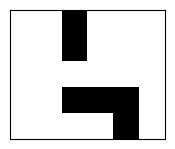

Orden de Exploración:
[0, 1, -1, 15, 19, 22]
[2, 3, -1, 12, 16, 20]
[4, 5, 7, 10, 13, 17]
[6, 8, -1, -1, -1, 21]
[9, 11, 14, 18, -1, 23]

Cuadrícula de Costos:
[0, 1, inf, 7, 8, 9]
[1, 2, inf, 6, 7, 8]
[2, 3, 4, 5, 6, 7]
[3, 4, inf, inf, inf, 8]
[4, 5, 6, 7, inf, 9]

Cuadrícula del Camino:
['>', 'v', ' ', ' ', ' ', ' ']
[' ', 'v', ' ', ' ', ' ', ' ']
[' ', '>', '>', '>', '>', 'v']
[' ', ' ', ' ', ' ', ' ', 'v']
[' ', ' ', ' ', ' ', ' ', '*']


In [9]:
# Prueba de la función de búsqueda
traversable = [[1, 1, 0, 1, 1, 1],
               [1, 1, 0, 1, 1, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 1, 0, 0, 0, 1],
               [1, 1, 1, 1, 0, 1]]
start = [0, 0]
goal = [len(traversable) - 1, len(traversable[0]) - 1]
cost = 1

path, exploration_order, cost_grid = search(traversable, start, goal, cost, max_steps=None)

show_map(traversable)
mostrar_resultados(exploration_order, cost_grid, path)

# Algoritmo A*


Se sabe que la principal diferencia entre el algoritmo de Dijkstra y A* es que el segundo emplea una función Heurística.

Según la implementación realizada, este cambio podemos realizarlo modificando la función `update_queue_cost`() y defininiendo una función para cálcular la heuristica mediante la distancia de Manhattan.

Esta distancia representa el número mínimo de movimientos necesarios para llegar al objetivo, asumiendo un movimiento horizontal o vertical por paso. Esta estimación es adecuada para entornos donde solo se permiten desplazamientos horizontales y verticales (sin diagonales).

In [10]:
def update_queue_cost(new_cost, open_list, x2, y2, method=None):
  if method == 'a_star':
    heuristic_cost = manhattan_heuristic([x2, y2], goal)
    total_cost = new_cost + heuristic_cost
    heapq.heappush(open_list, (total_cost, x2, y2))
  else:
    heapq.heappush(open_list, (new_cost, x2, y2))

def manhattan_heuristic(current, goal):
    """
    Heurística de Manhattan para estimar el costo restante al objetivo.

    Args:
        current (list of int): Coordenadas actuales [fila, columna].
        goal (list of int): Coordenadas del objetivo [fila, columna].

    Returns:
        int: Estimación del costo hasta el objetivo.
    """
    return abs(current[0] - goal[0]) + abs(current[1] - goal[1])


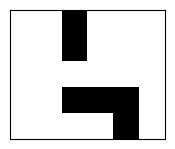

Orden de Exploración:
[0, 1, -1, -1, -1, -1]
[2, 3, -1, -1, -1, -1]
[4, 5, 6, 7, 8, 9]
[10, 11, -1, -1, -1, 12]
[13, 14, 15, 16, -1, 17]

Cuadrícula de Costos:
[0, 1, inf, inf, inf, inf]
[1, 2, inf, 6, 7, 8]
[2, 3, 4, 5, 6, 7]
[3, 4, inf, inf, inf, 8]
[4, 5, 6, 7, inf, 9]

Cuadrícula del Camino:
['>', 'v', ' ', ' ', ' ', ' ']
[' ', 'v', ' ', ' ', ' ', ' ']
[' ', '>', '>', '>', '>', 'v']
[' ', ' ', ' ', ' ', ' ', 'v']
[' ', ' ', ' ', ' ', ' ', '*']
---------------------------------------------------
Orden de Exploración:
[0, 1, -1, 15, 19, 22]
[2, 3, -1, 12, 16, 20]
[4, 5, 7, 10, 13, 17]
[6, 8, -1, -1, -1, 21]
[9, 11, 14, 18, -1, 23]

Cuadrícula de Costos:
[0, 1, inf, 7, 8, 9]
[1, 2, inf, 6, 7, 8]
[2, 3, 4, 5, 6, 7]
[3, 4, inf, inf, inf, 8]
[4, 5, 6, 7, inf, 9]

Cuadrícula del Camino:
['>', 'v', ' ', ' ', ' ', ' ']
[' ', 'v', ' ', ' ', ' ', ' ']
[' ', '>', '>', '>', '>', 'v']
[' ', ' ', ' ', ' ', ' ', 'v']
[' ', ' ', ' ', ' ', ' ', '*']


In [11]:
# Prueba de la función de búsqueda
traversable = [[1, 1, 0, 1, 1, 1],
               [1, 1, 0, 1, 1, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 1, 0, 0, 0, 1],
               [1, 1, 1, 1, 0, 1]]
start = [0, 0]
goal = [len(traversable) - 1, len(traversable[0]) - 1]
cost = 1

path, exploration_order, cost_grid = search(traversable, start, goal, cost, max_steps=None, method='a_star')

show_map(traversable)
mostrar_resultados(exploration_order, cost_grid, path)

path, exploration_order, cost_grid = search(traversable, start, goal, cost, max_steps=None, method='dijkstra')
print('---------------------------------------------------')
mostrar_resultados(exploration_order, cost_grid, path)

# Planificación - Programación Dinámica

Previamente se ha observado y comparado el resultado obtenido por los algoritmos de Dijkstra y A*, los cuales permiten obtener una ruta óptima hacia un destino deseado.

Sin embargo, al ser algoritmos de busqueda, estos suelen presentar una complejidad elevada para ser ejecutados continuamente en tiempo real. En robótica, el tiempo de ejecución de todo algoritmo es crítico por lo que si es posible se prefiere precalcular la ruta óptima para cada celda para posteriormente solo necesitar leer dicha ruta. Esto se puede realiza mediante una programación dinámica en el sigueinte código.

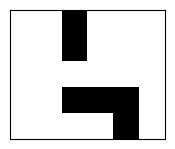

Matriz de Valores:
[12, 11, 99, 7, 6, 5]
[11, 10, 99, 6, 5, 4]
[10, 9, 99, 5, 4, 3]
[9, 8, 7, 6, 99, 2]
[10, 9, 99, 99, 99, 1]
[11, 10, 11, 12, 99, 0]

Matriz de Política:
['>', 'v', ' ', '>', '>', 'v']
['>', 'v', ' ', '>', '>', 'v']
['>', 'v', ' ', '>', '>', 'v']
['>', '>', '>', '^', ' ', 'v']
['^', '^', ' ', ' ', ' ', 'v']
['^', '^', '<', '<', ' ', '*']


In [13]:
import heapq  # Importamos heapq para funcionalidad de cola de prioridad

# Definimos la cuadrícula y el objetivo
grid = [[1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 0, 1]]

# Establecemos la posición del objetivo como la esquina derecha inferior
goal = [len(grid) - 1, len(grid[0]) - 1]
cost = 1  # Costo por moverse a una celda adyacente

# Direcciones y símbolos para los movimientos
DIRECTIONS = [(-1, 0), (0, -1), (1, 0), (0, 1)]  # arriba, izquierda, abajo, derecha
DIRECTION_SYMBOLS = ['^', '<', 'v', '>']

def optimum_policy(grid, goal, cost):
    rows, cols = len(grid), len(grid[0])

    # Inicializa las matrices de valor y política
    value = [[99] * cols for _ in range(rows)]
    policy = [[' '] * cols for _ in range(rows)]

    # Cola de prioridad usando heapq
    open_list = []
    heapq.heappush(open_list, (0, goal[0], goal[1])) # Inicia desde el objetivo con costo 0

    value[goal[0]][goal[1]] = 0
    policy[goal[0]][goal[1]] = '*'

    # Bucle principal para explorar la cuadrícula
    while open_list:
        current_value, x, y = heapq.heappop(open_list)  # Extrae la celda con el valor más bajo

        # Explora celdas vecinas
        for action, (dx, dy) in enumerate(DIRECTIONS):
            x2, y2 = x + dx, y + dy

            # Comprueba que la celda está dentro de los límites y es transitable
            if is_within_bounds(x2, y2, grid) and grid[x2][y2]:
                new_value = current_value + cost

                # Actualiza si encontramos un camino de menor costo
                if new_value < value[x2][y2]:
                    value[x2][y2] = new_value
                    policy[x2][y2] = DIRECTION_SYMBOLS[(action + 2) % 4] # Invertimos la dirección
                    heapq.heappush(open_list, (new_value, x2, y2))

    # Imprimir resultados
    print("Matriz de Valores:")
    for row in value:
        print(row)
    print("\nMatriz de Política:")
    for row in policy:
        print(row)

# Ejecutar la función de política óptima
show_map(traversable)
optimum_policy(grid, goal, cost)
